In [15]:
import json

with open('../data/celebvhq_info.json', 'r') as f:
    data = json.load(f)

In [16]:
emotion_dict = {}

for clip in data['clips'].keys():
    videofile = '../data/35666/' + clip + '.mp4'
    duration = data['clips'][clip]['duration']['end_sec'] - data['clips'][clip]['duration']['start_sec']
    bbox = data['clips'][clip]['bbox']
    emotions = data['clips'][clip]['attributes']['emotion']['labels']
    if type(emotions) == str:
        emotions = [{'emotion': emotions, 'start_sec': 0, 'end_sec': duration}]
    if any(emotion['end_sec'] - emotion['start_sec'] < 0 for emotion in emotions):
        continue
    for emotion in emotions:
        if(emotion['emotion'] == 'contempt'):
            emotion['emotion'] = 'disgust'
        if(emotion['emotion'] == 'fear'):
            emotion['emotion'] = 'sadness'
    emotion_dict[videofile] = emotions

emotion_dict


{'../data/35666/M2Ohb0FAaJU_1.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 4.549999999999997}],
 '../data/35666/_0tf2n3rlJU_0.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 0.28000000000000114},
  {'emotion': 'happy',
   'start_sec': 1.2800000000000011,
   'end_sec': 3.280000000000001}],
 '../data/35666/dvbePi1o_Q0_1.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 5.920000000000002}],
 '../data/35666/ekdWbe1s_d4_0.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 3.770000000000003}],
 '../data/35666/ekdWbe1s_d4_1.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 7.280000000000001}],
 '../data/35666/HV150LwK8Kc_8.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 4.1200000000000045}],
 '../data/35666/vtznSlhouZc_0.mp4': [{'emotion': 'neutral',
   'start_sec': 0,
   'end_sec': 4.339999999999996}],
 '../data/35666/WYIsBYSO0gc_11.mp4': [{'emotion': 'happy',
   'start_sec': 0,
   'end_sec': 4.870000000000

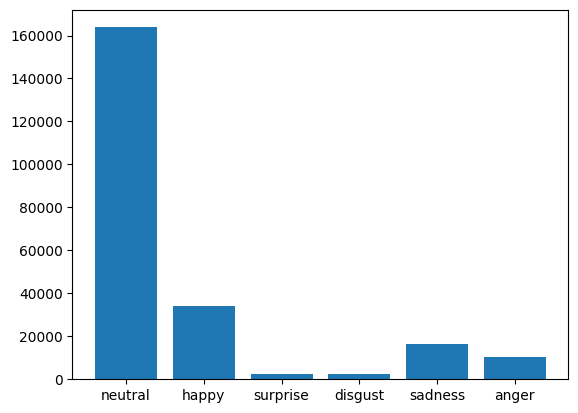

{'neutral': 163829.07000000105, 'happy': 34020.50999999987, 'surprise': 2447.310000000001, 'disgust': 2281.8199999999997, 'sadness': 16211.249999999873, 'anger': 10272.120000000046}


In [17]:
import matplotlib.pyplot as plt

def plot_time_distribution(emotion_dict):
    total_time = {}
    for clip in emotion_dict.keys():
        for emotion in emotion_dict[clip]:
            if(emotion['end_sec'] - emotion['start_sec'] < 0):
                print(clip, emotion['end_sec'] - emotion['start_sec'])
            total_time[emotion['emotion']] = total_time.get(emotion['emotion'], 0) + emotion['end_sec'] - emotion['start_sec']
    plt.bar(total_time.keys(), total_time.values())
    plt.show()
    print(total_time)

plot_time_distribution(emotion_dict)

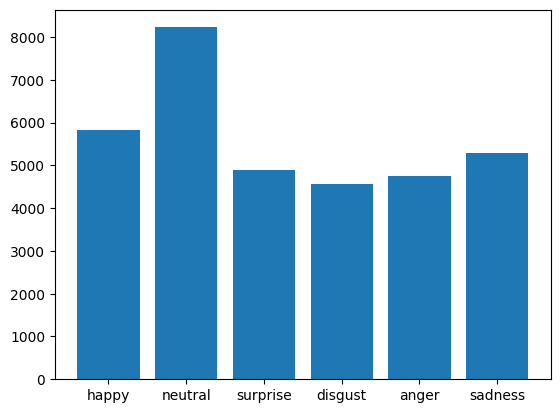

{'happy': 5819.239999999998, 'neutral': 8225.790000000012, 'surprise': 4894.620000000016, 'disgust': 4563.64000000001, 'anger': 4749.720000000014, 'sadness': 5280.280000000023}


In [18]:
import numpy as np

for clip in list(emotion_dict.keys()):
    for emotion in emotion_dict[clip]:
        if emotion['emotion'] in ['surprise', 'disgust']:
            flipped_key = clip.replace('.mp4', '_flipped.mp4')
            emotion_dict[flipped_key] = emotion_dict[clip].copy()

for clip in emotion_dict.keys():
    for emotion in emotion_dict[clip]:
        if(emotion['emotion'] == 'neutral' and np.random.randint(0, 100) > 3):
            emotion_dict[clip].remove(emotion)
        elif(emotion['emotion'] == 'happy' and np.random.randint(0, 100) > 10):
            emotion_dict[clip].remove(emotion)
        elif(emotion['emotion'] == 'sadness' and np.random.randint(0, 100) > 30):
            emotion_dict[clip].remove(emotion)
        elif(emotion['emotion'] == 'anger' and np.random.randint(0, 100) > 40):
            emotion_dict[clip].remove(emotion)

plot_time_distribution(emotion_dict)

In [19]:
import cv2
import mediapipe as mp
import pandas as pd

In [20]:
mp_face_mes = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
face_mesh = mp_face_mes.FaceMesh(max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [21]:
def inference_facemesh(image):
    try:
        frame = image.copy()
    except AttributeError:
        return None
    H, W, _ = frame.shape
    rgb_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results_mesh = face_mesh.process(rgb_image)
    if results_mesh.multi_face_landmarks:
        mesh_points=np.array([np.multiply([p.x, p.y, p.z], [W, H, max(W, H)]).astype(int) for p in results_mesh.multi_face_landmarks[0].landmark])
        return mesh_points
    return None

In [22]:
def resize_if_too_small(photo):
    if photo.shape[0] < 300 and photo.shape[1] < 300:
        photo = cv2.resize(photo, (300, 300), interpolation = cv2.INTER_CUBIC)
    return photo

In [23]:
def normalize_landmarks(mesh):
    nose_tip = mesh[4] 
    forehead = mesh[151]
    mesh_norm = mesh - nose_tip
    scale_factor = np.linalg.norm(forehead - nose_tip)
    if np.isclose(scale_factor, 0):
        scale_factor = 1e-6
    mesh_norm = np.divide(mesh_norm, scale_factor)
    landmarks_flat = mesh_norm.flatten()
    return landmarks_flat

In [24]:
df = pd.DataFrame(columns=['label', 'video', 'frame', 'landmarks'])
total_videos = len(emotion_dict.keys())
processed_videos = 0

for video in emotion_dict.keys():
    flipped = False
    if video.endswith('_flipped.mp4'):
        flipped = True
        video = video.replace('_flipped.mp4', '.mp4')
    vidcap = cv2.VideoCapture(video)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    for emotion in emotion_dict[video]:
        start_frame = int(emotion['start_sec'] * fps)
        end_frame = int(emotion['end_sec'] * fps)
        for frame_number in range(start_frame, end_frame):
            vidcap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
            ret, frame = vidcap.read()
            if frame is None:
                continue
            if flipped:
                frame = cv2.flip(frame, 1)
            landmarks = inference_facemesh(resize_if_too_small(frame))
            if landmarks is None:
                continue
            landmarks = normalize_landmarks(landmarks)
            new_row = pd.DataFrame([{'label': emotion['emotion'], 
                                'video': video, 
                                'frame': frame_number, 
                                'landmarks': landmarks}])
            df = pd.concat([df, new_row], ignore_index=True)
    print(f"{processed_videos}/{total_videos} ({round(processed_videos/total_videos*100, 2)}%) - {video}")
    processed_videos += 1

0/36620 (0.0%) - ../data/35666/M2Ohb0FAaJU_1.mp4
1/36620 (0.0%) - ../data/35666/_0tf2n3rlJU_0.mp4
2/36620 (0.01%) - ../data/35666/dvbePi1o_Q0_1.mp4
3/36620 (0.01%) - ../data/35666/ekdWbe1s_d4_0.mp4
4/36620 (0.01%) - ../data/35666/ekdWbe1s_d4_1.mp4
5/36620 (0.01%) - ../data/35666/HV150LwK8Kc_8.mp4
6/36620 (0.02%) - ../data/35666/vtznSlhouZc_0.mp4
7/36620 (0.02%) - ../data/35666/WYIsBYSO0gc_11.mp4
8/36620 (0.02%) - ../data/35666/I2hf-H8Xumk_3.mp4
9/36620 (0.02%) - ../data/35666/WYIsBYSO0gc_10.mp4
10/36620 (0.03%) - ../data/35666/vtznSlhouZc_1.mp4
11/36620 (0.03%) - ../data/35666/M52PPU55qRQ_0.mp4
12/36620 (0.03%) - ../data/35666/I2hf-H8Xumk_2.mp4
13/36620 (0.04%) - ../data/35666/mrm31EMpIi8_12.mp4
14/36620 (0.04%) - ../data/35666/1id56m17lko_0.mp4
15/36620 (0.04%) - ../data/35666/mrm31EMpIi8_13.mp4
16/36620 (0.04%) - ../data/35666/BQU7_l5pjAk_4.mp4
17/36620 (0.05%) - ../data/35666/SN8buDY-7LM_0.mp4
18/36620 (0.05%) - ../data/35666/mq5I7jFZ3Sk_2.mp4
19/36620 (0.05%) - ../data/35666/IpoReT

In [27]:
df.head(10)

,label,video,frame,landmarks
0,happy,../data/35666/_0tf2n3rlJU_0.mp4,30,"[0.09155383634728674, 0.45072657894048856, 0.1..."
1,happy,../data/35666/_0tf2n3rlJU_0.mp4,31,"[0.04696611706300864, 0.40927616297764674, 0.1..."
2,happy,../data/35666/_0tf2n3rlJU_0.mp4,32,"[0.047119087721749775, 0.41060919300381943, 0...."
3,happy,../data/35666/_0tf2n3rlJU_0.mp4,33,"[0.04064085637869828, 0.4199555159132155, 0.17..."
4,happy,../data/35666/_0tf2n3rlJU_0.mp4,34,"[0.06152560852783227, 0.4306792596948259, 0.17..."
5,happy,../data/35666/_0tf2n3rlJU_0.mp4,35,"[0.0760922318890177, 0.42888348882900884, 0.17..."
6,happy,../data/35666/_0tf2n3rlJU_0.mp4,36,"[0.0677037053085323, 0.40622223185119377, 0.18..."
7,happy,../data/35666/_0tf2n3rlJU_0.mp4,37,"[0.061309665810664785, 0.4155432904945057, 0.1..."
8,happy,../data/35666/_0tf2n3rlJU_0.mp4,38,"[0.07422780688384442, 0.41162692908313725, 0.1..."
9,happy,../data/35666/_0tf2n3rlJU_0.mp4,39,"[0.06730231008039023, 0.40381386048234136, 0.1..."


In [26]:
df.to_parquet('../data/landmarks.parquet', index=False)